In [46]:
from database import Database, LoadDatabase
from numba import njit, vectorize
import matplotlib.pyplot as plt
from atcoder import *
import numpy as np
import pickle
import os

os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
CALCS_FILE = "calcs.pickle"

In [60]:
# if calculated and save before, load it from file
if os.path.exists(CALCS_FILE):
    with open(CALCS_FILE, "rb") as infile:
        db, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt = pickle.load(infile)
else:
    # load database
    db = LoadDatabase()

    # collect all handles in all standings
    all_handles = set()
    for standings in db.standings.values():
        for handle in standings.index:
            all_handles.add(handle)

    # create to way mappings (id, handle)
    handle_to_id = {handle: i for i, handle in enumerate(all_handles)}
    id_to_handle = {i: handle for handle, i in handle_to_id.items()}

    # sort standings by startTime
    sorted_standings = [(k, v) for k, v in sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)]

    # merge handles, ranks and standings length into flat array
    handle_ids_merged = []
    ranks_merged = []
    standings_lengths_merged = []

    for c_id, standings in sorted_standings:
        standings = standings.sort_values("rank")
        for handle in standings.index:
            handle_ids_merged.append(handle_to_id[handle])
            ranks_merged.append(standings["rank"][handle])
        standings_lengths_merged.append(len(standings))

    # convert them to numpy array
    handle_ids = np.array(handle_ids_merged, dtype=np.int32)
    ranks = np.array(ranks_merged, dtype=np.int32)
    standings_lens = np.array(standings_lengths_merged, dtype=np.int32)
    user_contest_cnt = np.bincount(handle_ids)
    
    with open(CALCS_FILE, "wb") as outfile:
        obj = (db, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt)
        pickle.dump(obj, outfile)

In [241]:
CENTER = 1200
RATEDBOUND = np.inf

def get_first_K_contests(K):
    K_standings_len = np.sum(standings_lens[:K])
    K_handle_ids = handle_ids[:K_standings_len]
    K_ranks = ranks[:K_standings_len]
    K_standings_lens = standings_lens[:K]
    K_user_contest_cnt = np.bincount(K_handle_ids)
    return K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt

@vectorize
def powersum(q, n):
    return q * (1 - q**n) / (1 - q)

@vectorize
def g(x):
    return np.power(2, x / 800)

@vectorize
def ginv(y):
    return 800 * np.log2(y)

@vectorize
def F(n):
    return np.sqrt(powersum(0.81, n)) / powersum(0.9, n)

@vectorize
def f(n):
    Finf = np.sqrt(0.81 / (1.0 - 0.81)) / (0.9 / (1.0 - 0.9))
    return (F(n) - Finf) / (F(1) - Finf) * CENTER

@njit
def calc(handle_ids, ranks, standings_lens, user_contest_cnt, verbose=True):
    user_cnt = len(user_contest_cnt)
    standings_cnt = len(standings_lens)
    history_cnt = len(handle_ids)
    
    nums = np.zeros(user_cnt, dtype=np.float64)
    dens = np.zeros(user_cnt, dtype=np.float64)
    aperfs = np.full(user_cnt, CENTER, dtype=np.float64)
    perfs = np.empty(history_cnt, dtype=np.float64)
    ratings = np.zeros(history_cnt, dtype=np.float64)
    offsets = np.cumsum(user_contest_cnt) - user_contest_cnt
    local_offsets = np.zeros(user_cnt, dtype=np.int32)
    
    standings_offset = 0
    standings_left = len(standings_lens)
    
    for i in range(standings_cnt):
        if verbose:
            print("Standings left:", standings_left)
        standings_left -= 1
        
        standings_len = standings_lens[i]
        for j in range(standings_len):
            rank = ranks[standings_offset + j]

            l, r = 0, 5000
            max_iters = 80
            while max_iters > 0 and (r - l) > 1e-1:
                m = (l + r) / 2
                val = 0.0
                for k in range(standings_len):
                    handle_id = handle_ids[standings_offset + k]
                    aperf = aperfs[handle_id]
                    val += 1 / (1 + np.power(6, (m - aperf) / 400))
                if val > rank - 0.5:
                    l = m
                else:
                    r = m
                max_iters -= 1
            perf = l
    
            handle_id = handle_ids[standings_offset + j]
            offset = offsets[handle_id]
            local_offset = local_offsets[handle_id]
            
            if local_offset == 0:
                perf = (perf - CENTER) * 1.5 + CENTER
                ratings[offset + local_offset] = CENTER
            else:
                den = dens[handle_id]
                last_sum = g(ratings[offset + local_offset - 1]) * den
                rperf = min(perfs[offset + local_offset - 1], RATEDBOUND + 400)
                ratings[offset + local_offset] = ginv((0.9 * (last_sum + g(rperf))) / (0.9 * (1 + den)))
                
            perfs[offset + local_offset] = perf
            nums[handle_id] = 0.9 * (perf + nums[handle_id])
            dens[handle_id] = 0.9 * (1 + dens[handle_id])
            local_offsets[handle_id] += 1
        
        for j in range(standings_len):
            handle_id = handle_ids[standings_offset + j]
            aperfs[handle_id] = nums[handle_id] / dens[handle_id]
        
        standings_offset += standings_len
    
    return nums, dens, aperfs, perfs, ratings, offsets, local_offsets

In [176]:
# we will consider `consider` first standings
consider = 50

In [229]:
# compile (jit)
compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt = \
    get_first_K(5, handle_ids, ranks, standings_lens, user_contest_cnt)
calc(compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt, verbose=False)

# calculate
K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt = \
    get_first_K(consider, handle_ids, ranks, standings_lens, user_contest_cnt)
%time nums, dens, aperfs, perfs, ratings, offsets, local_offsets = \
    calc(K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt)

for i in range(len(K_user_contest_cnt)):
    assert K_user_contest_cnt[i] == local_offsets[i]

Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
CPU times: user 7.65 s, sys: 9.96 ms, total: 7.66 s
Wall ti

In [17]:
%time ans, userRatings = AtCoderRatingSystem(db, consider=consider, verbose=True)

Standings left: 250 contestId: 26
Standings left: 249 contestId: 27
Standings left: 248 contestId: 28
Standings left: 247 contestId: 29
Standings left: 246 contestId: 30
Standings left: 245 contestId: 31
Standings left: 244 contestId: 32


KeyboardInterrupt: 

In [205]:
def get_cf_ratings(handle):
    ans = []
    for contestId, standings in sorted_standings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["oldRating"])
    return ans

def get_random_user(user_contest_cnt, threshold=10):
    handle_ids = np.arange(len(user_contest_cnt))
    mask = user_contest_cnt > threshold
    handle_id = np.random.choice(handle_ids[mask])
    return id_to_handle[handle_id]

def plot_handle(handle, nums, dens, aperfs, perfs, ratings, offsets, user_contest_cnt):
    handle_id = handle_to_id[handle]
    contest_cnt = user_contest_cnt[handle_id]
    user_offset = offsets[handle_id]
    user_perfs = perfs[user_offset:user_offset+contest_cnt]
    user_ratings = ratings[user_offset:user_offset+contest_cnt]
    cf_ratings = get_cf_ratings(handle)
    assert len(user_perfs) == len(cf_ratings)
    assert len(user_ratings) == len(cf_ratings)
    print("number of contests", len(cf_ratings))
    xs = np.arange(len(cf_ratings))
    print(user_perfs)
    print(aperfs[handle_id])
    print(dens[handle_id])
    print(nums[handle_id])
    
    plt.figure(figsize=(15, 8))
    plt.plot(xs, user_ratings, label="AtCoder")
    plt.plot(xs, cf_ratings, label="CodeForces")
#     plt.plot(xs, user_perfs, label="AtCoderPerfs")
    plt.title(handle)
    plt.legend()
    plt.show()

number of contests 43
[ 915.54107666 1323.16589355  915.14587402  674.43847656  972.29003906
 1142.65441895 1307.98339844  626.44958496  679.62646484  936.6607666
  692.74902344  727.23388672 1666.18347168 1248.16894531 1321.71630859
 1317.44384766  966.18652344 1986.69433594 1161.88049316  543.97583008
  487.82348633 1036.60583496 1451.41601562  875.7019043   887.37487793
  407.94372559 1203.15551758 1598.81591797 1286.39221191  558.77685547
  778.0456543  1118.69812012 1038.97094727 1165.54260254  951.08032227
  943.37463379 1022.8729248  1371.15478516  705.18493652  566.32995605
 1287.46032715 1039.35241699 1521.7590332 ]
1059.3830109421144
8.90302262702125
9431.710917099545


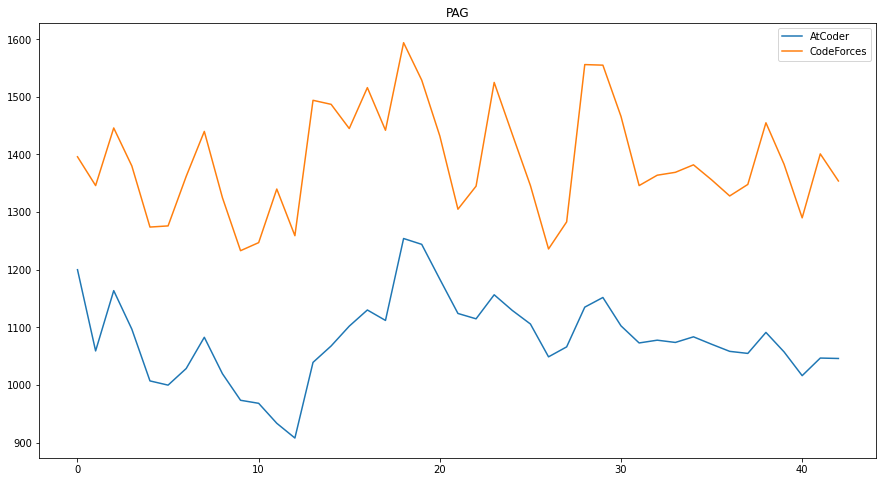

In [240]:
handle = getRandomUser(K_user_contest_cnt, threshold=30)
# handle = "PAG"
plot_handle(handle, nums, dens, aperfs, perfs, ratings, offsets, K_user_contest_cnt)